## Product Recommendation System for Instacart Dataset

Recommendation systems are widely used in online marketplaces and some retailers are using this technology to improve user experience, user retention, and conversion rate. Online marketplaces such as Amazon, you will find some recommendations such as frequently bought together, customers who bought this also bought this, similar items, and so on. 
 
We will employ collaborative filtering method content-based collaborative filtering on warm start a problem using Instacart Dataset for transactional product data recomendation.

- The user-item interaction matrix defines the interaction between the user (customer) to the item (product), in the retail case, we can’t take an explicit rating from the historical data. We can take into account the “number of purchases” as the rating. The user-item interaction matrix represents the collaborative filtering contribution to the model.

- The item-feature interaction matrix defines the features of the items. Item to features can be represented as a product to its metadata such as the product’s category, sub-category, or even any pieces of information. We use “aisles” and “department” as the products’ features. If product A is located in aisle B, then we can say the matrix element of product A in aisle B is 1 and 0 in otherwise. This matrix can add content-based contributions to the model.

### Instacart Market Basket dataset

Data contains customer, product, order, aisle information, and which products were purchased in each order. 

Source: https://www.kaggle.com/c/instacart-market-basket-analysis/data

In [53]:
import pandas as pd # pandas for data manipulation
import numpy as np # numpy for sure
from scipy.sparse import coo_matrix # for constructing sparse matrix
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

# lightfm 
from lightfm import LightFM # model
from lightfm.evaluation import auc_score

# timing
import time

we need one sparse matrix named as user-item interaction matrix. For the hybrid collaborative — content recommendation case, we can also add item-feature matrix into consideration.

In [2]:
# load data
orders      = pd.read_csv("../data/orders.csv")
products    = pd.read_csv("../data/products.csv")
aisles      = pd.read_csv("../data/aisles.csv")
departments = pd.read_csv("../data/departments.csv")

order_products_train = pd.read_csv("../data/order_products__train.csv")
order_products_prior = pd.read_csv("../data/order_products__prior.csv")

In [3]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [5]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [8]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


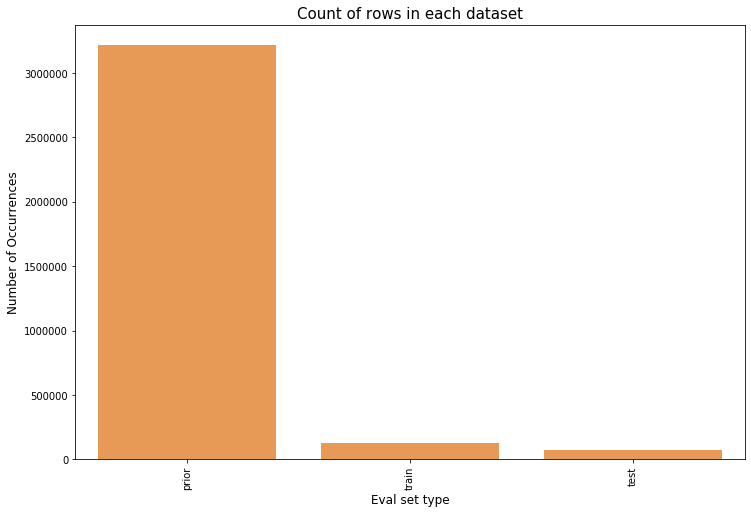

In [54]:
cnt_srs = orders.eval_set.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

For this dataset, 4 to 100 orders of a customer are given and we need to predict the products that will be re-ordered. So the last order of the user has been taken out and divided into train and test sets. All the prior order informations of the customer are present in order_products_prior file. We can also note that there is a column in orders.csv file called eval_set which tells us as to which of the three datasets (prior, train or test) the given row goes to.

In [56]:
def get_unique_count(x):
    return len(np.unique(x))

In [57]:
cnt_srs = orders.groupby("eval_set")["user_id"].aggregate(get_unique_count)
print(cnt_srs)

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64


So there are 206,209 customers in total. Out of which, the last purchase of 131,209 customers are given as train set and we need to predict for the rest 75,000 customers.

Now let us validate the claim that 4 to 100 orders of a customer are given.

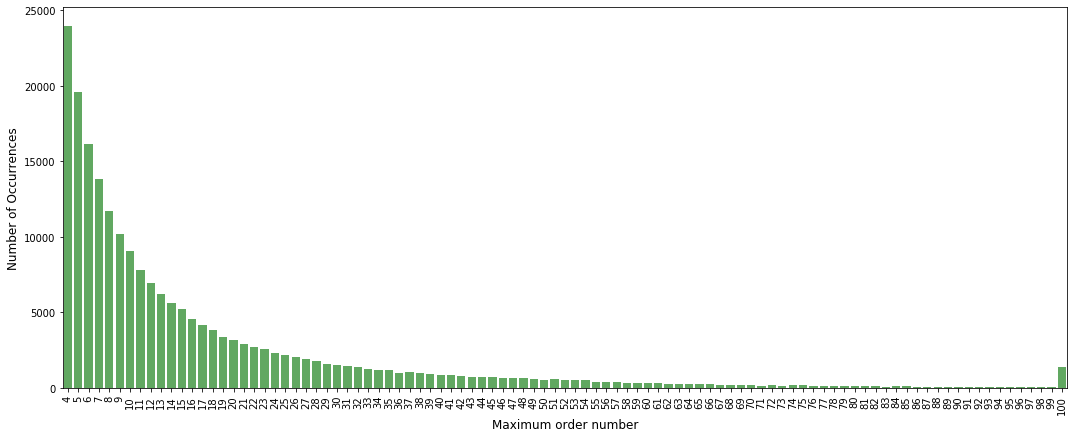

In [62]:
cnt_srs = orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(18,7))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

So there are no orders less than 4 and is max capped at 100 as given in the data page.

Now let us see how the ordering habit changes with day of week.

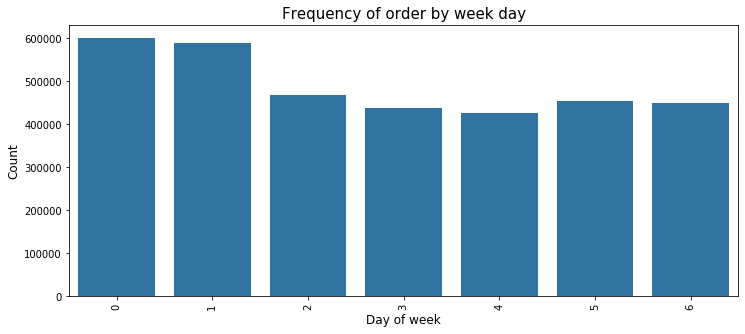

In [67]:
plt.figure(figsize=(12, 5))
sns.countplot(x="order_dow", data=orders, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

Seems like 0 and 1 is Saturday and Sunday when the orders are high and low during Wednesday.

Now we shall see how the distribution is with respect to time of the day.

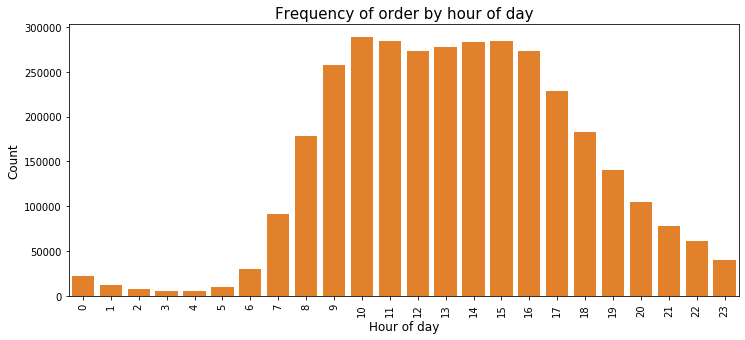

In [69]:
plt.figure(figsize=(12, 5))
sns.countplot(x="order_hour_of_day", data=orders, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

So majority of the orders are made during day time. Now let us combine the day of week and hour of day to see the distribution.

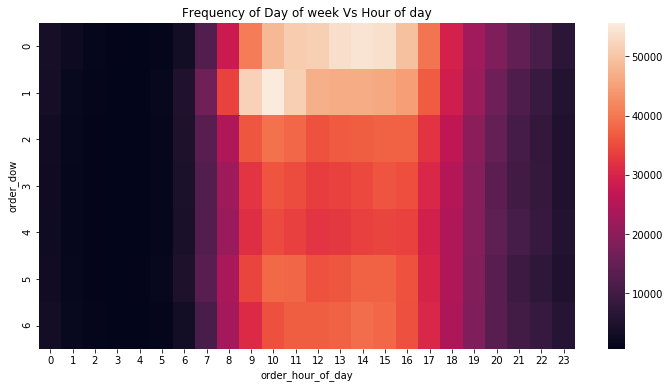

In [72]:
grouped = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped = grouped.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

Seems Satuday evenings and Sunday mornings are the prime time for orders.

Now let us check the time interval between the orders.

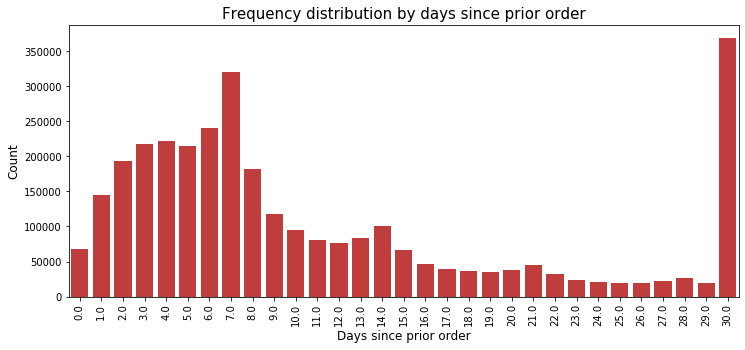

In [74]:
plt.figure(figsize=(12, 5))
sns.countplot(x="days_since_prior_order", data=orders, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

Remove samples (rows) with missing info

Looks like customers order once in every week (check the peak at 7 days) or once in a month (peak at 30 days). We could also see smaller peaks at 14, 21 and 28 days (weekly intervals).

Since our objective is to figure out the re-orders, let us check out the re-order percentage in prior set and train set.

In [76]:
# percentage of re-orders in prior set #
order_products_prior.reordered.sum() / order_products_prior.shape[0]

0.5896974667922161

In [77]:
# percentage of re-orders in train set #
order_products_train.reordered.sum() / order_products_train.shape[0]

0.5985944127509629

On an average, about 59% of the products in an order are re-ordered products.

#### No re-ordered products:

Now that we have seen 59% of the products are re-ordered, there will also be situations when none of the products are re-ordered.

In [81]:
grouped_data = order_products_prior.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_data["reordered"].loc[grouped_data["reordered"]>1] = 1
grouped_data.reordered.value_counts() / grouped_data.shape[0]

1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [83]:
grouped_data = order_products_train.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_data["reordered"].loc[grouped_data["reordered"]>1] = 1
grouped_data.reordered.value_counts() / grouped_data.shape[0]

1    0.93444
0    0.06556
Name: reordered, dtype: float64

About 12% of the orders in prior set has no re-ordered items while in the train set it is 6.5%.

Let's now see the number of products bought in each order.

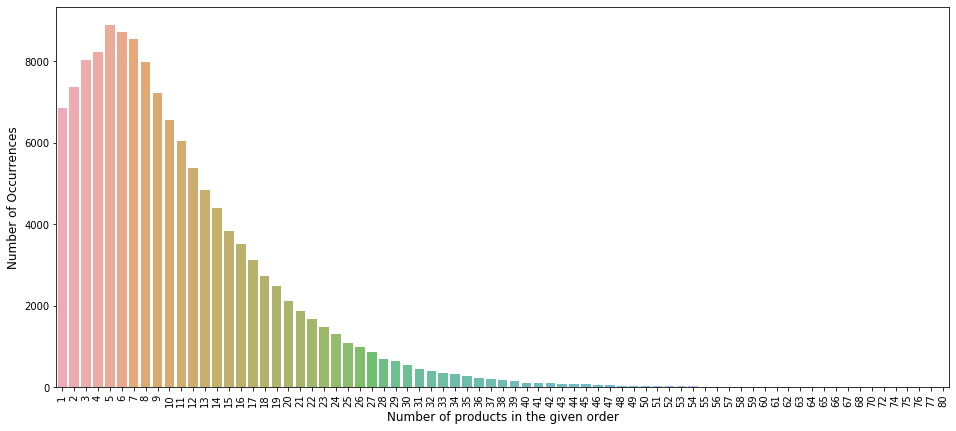

In [88]:
grouped_data = order_products_train.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_data.add_to_cart_order.value_counts()

plt.figure(figsize=(16, 7))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

A right tailed distribution with the maximum value at 5.!

Let's merge these product details with the order_prior details.

In [89]:
order_products_prior_merge = pd.merge(order_products_prior, products, on='product_id', how='left')
order_products_prior_merge = pd.merge(order_products_prior_merge, aisles, on='aisle_id', how='left')
order_products_prior_merge = pd.merge(order_products_prior_merge, departments, on='department_id', how='left')
order_products_prior_merge.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [90]:
cnt_srs = order_products_prior_merge['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs.head()

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584


Most of them are organic products. Also majority of them are fruits.

Let's look at the important aisles.

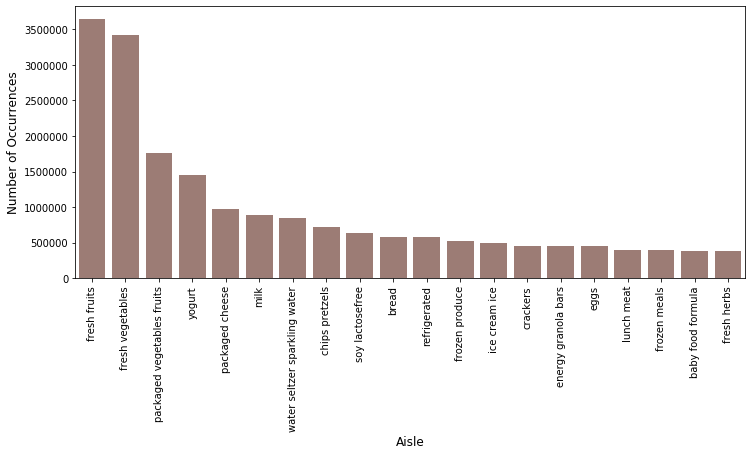

In [93]:
cnt_srs = order_products_prior_merge['aisle'].value_counts().head(20)

plt.figure(figsize=(12, 5))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

The top two aisles are fresh fruits and fresh vegetables.

#### Department Distribution

Let's check the department wise distribution.

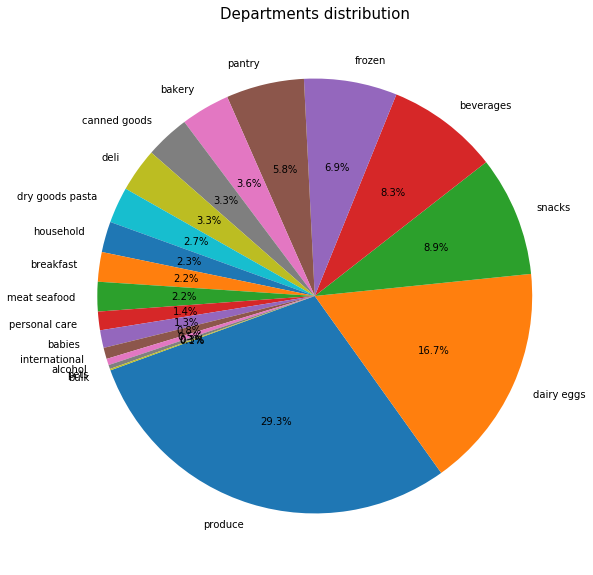

In [94]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior_merge['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

Produce is the largest department. Now let us check the reordered percentage of each department.

In [ ]:
# Department wise reorder ratio:
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

Personal care has lowest reorder ratio and dairy eggs have highest reorder ratio.

Aisle - Reorder ratio:

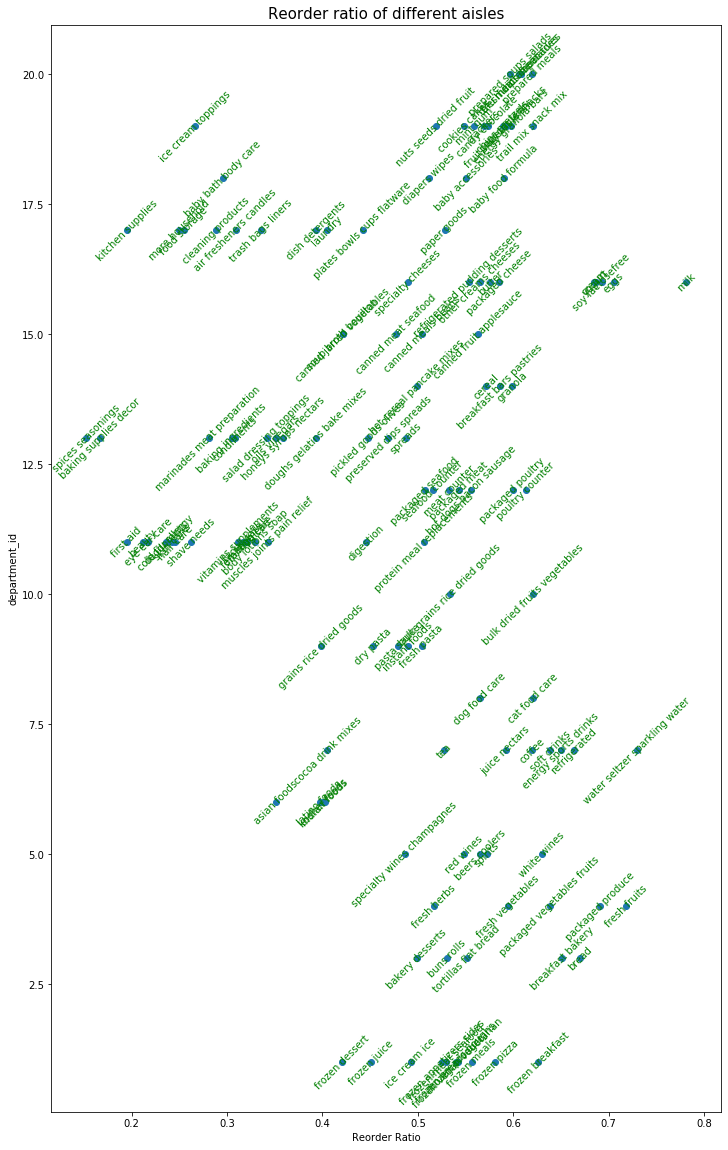

In [96]:
grouped_ratio = order_products_prior_merge.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_ratio.reordered.values, grouped_ratio.department_id.values)
for i, txt in enumerate(grouped_ratio.aisle.values):
    ax.annotate(txt, (grouped_ratio.reordered.values[i],
                      grouped_ratio.department_id.values[i]), 
                rotation=45, ha='center', va='center', color='green')
plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

#### Add to Cart - Reorder ratio

Let's explore the relationship between how order of adding the product to the cart affects the reorder ratio.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


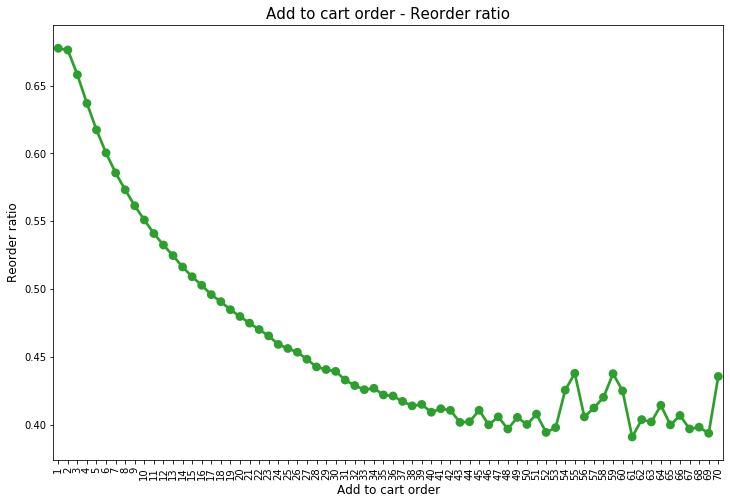

In [97]:
order_products_prior_merge["add_to_cart_order_mod"] = order_products_prior_merge["add_to_cart_order"].copy()
order_products_prior_merge["add_to_cart_order_mod"].loc[order_products_prior_merge["add_to_cart_order_mod"]>70] = 70
grouped_ratio = order_products_prior_merge.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_ratio['add_to_cart_order_mod'].values,
              grouped_ratio['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

Looks like the products that are added to the cart initially are more likely to be reordered again compared to the ones added later. This makes sense to me as well since we tend to first order all the products we used to buy frequently and then look out for the new products available.

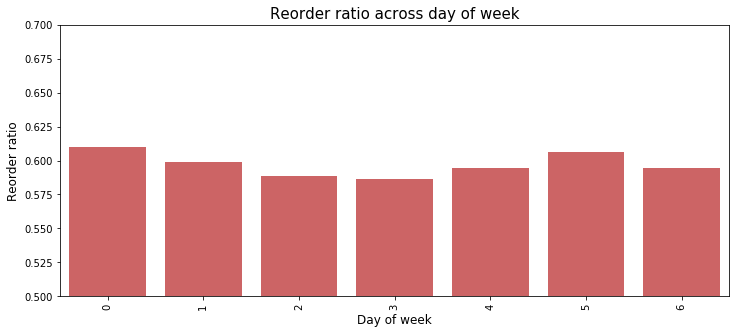

In [100]:
# Reorder ratio by Time based variables
order_products_train_merge = pd.merge(order_products_train, orders, on='order_id', how='left')
grouped_ratio = order_products_train_merge.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12, 5))
sns.barplot(grouped_ratio['order_dow'].values, 
            grouped_ratio['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

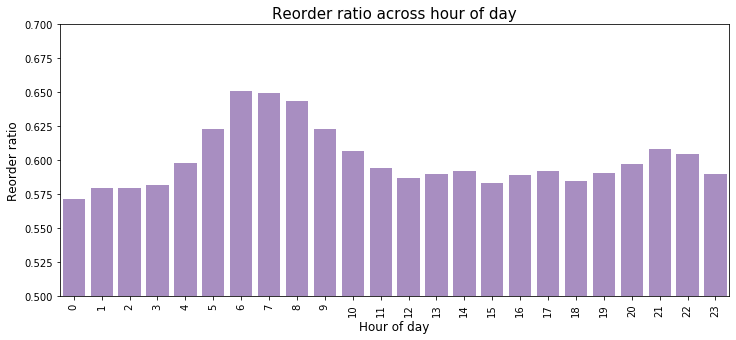

In [102]:
grouped_ratio = order_products_train_merge.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12, 5))
sns.barplot(grouped_ratio['order_hour_of_day'].values, 
            grouped_ratio['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

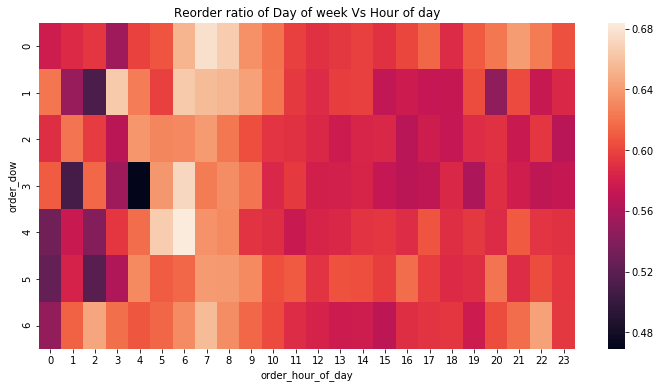

In [103]:
grouped_ratio = order_products_train_merge.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_ratio = grouped_ratio.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_ratio)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

Looks like reorder ratios are quite high during the early mornings compared to later half of the day.

In [9]:
# removing aisles with aisle == "missing" and aisle == "other"
aisles = aisles[aisles["aisle"].apply(lambda x: x != "missing" and x != "other")]

# removing departments with department == "missing" and department == "other"
departments = departments[departments["department"].apply(lambda x: x != "missing" and x != "other")]

We creating dictionary mappings for user_id to index, index to user_id, item_id to index, and index to item_id for user-item interaction matrix. And convert the items/products and features interactions into a sparse matrix (item-feature matrix).

In [20]:
# The matrix generators and some helper functions for indexing 
def get_user_list(df, user_column):
    """
    
    creating a list of user from dataframe df, user_column is a column 
    consisting of users in the dataframe df
    
    """
    
    return np.sort(df[user_column].unique())

def get_item_list(df, item_name_column):
    
    """
    
    creating a list of items from dataframe df, item_column is a column 
    consisting of items in the dataframe df
    
    return to item_id_list and item_id2name_mapping
    
    """
    
    item_list = df[item_name_column].unique()
    
    
    return item_list

def get_feature_list(aisle_df, department_df, aisle_name_column, department_name_column):
    
    aisle = aisle_df[aisle_name_column]
    department = department_df[department_name_column]
    
    return pd.concat([aisle, department], ignore_index = True).unique()

# creating user_id, item_id, and features_id

def id_mappings(user_list, item_list, feature_list):
    """
    
    Create id mappings to convert user_id, item_id, and feature_id
    
    """
    user_to_index_mapping = {}
    index_to_user_mapping = {}
    for user_index, user_id in enumerate(user_list):
        user_to_index_mapping[user_id] = user_index
        index_to_user_mapping[user_index] = user_id
        
    item_to_index_mapping = {}
    index_to_item_mapping = {}
    for item_index, item_id in enumerate(item_list):
        item_to_index_mapping[item_id] = item_index
        index_to_item_mapping[item_index] = item_id
        
    feature_to_index_mapping = {}
    index_to_feature_mapping = {}
    for feature_index, feature_id in enumerate(feature_list):
        feature_to_index_mapping[feature_id] = feature_index
        index_to_feature_mapping[feature_index] = feature_id
        
        
    return user_to_index_mapping, index_to_user_mapping, \
           item_to_index_mapping, index_to_item_mapping, \
           feature_to_index_mapping, index_to_feature_mapping


def get_user_product_interaction(orders_df, order_products_train_df, order_products_test_df, products_df):
    
    # creating a dataframe consists of TWO columns user_id, and product_name (product bought by the user) for the train data
    user_to_product_train_df = orders_df[orders_df["eval_set"] == "prior"][["user_id", "order_id"]].\
    merge(order_products_train_df[["order_id", "product_id"]]).merge(products_df[["product_id", "product_name"]])\
    [["user_id", "product_name"]].copy()
    
    # giving rating as the number of product purchase count
    user_to_product_train_df["product_count"] = 1
    user_to_product_rating_train = user_to_product_train_df.groupby(["user_id", "product_name"], as_index = False)["product_count"].sum()
    
    # creating a dataframe consists of TWO columns user_id, and product_name (product bought by the user) for the test data
    user_to_product_test_df = orders_df[orders_df["eval_set"] == "train"][["user_id", "order_id"]].\
    merge(order_products_test_df[["order_id", "product_id"]]).merge(products_df[["product_id", "product_name"]])\
    [["user_id", "product_name"]].copy()
    
    # giving rating as the number of product purchase count (including the previous purchase in the training data)
    user_to_product_test_df["product_count"] = 1
    user_to_product_rating_test = user_to_product_test_df.groupby(["user_id", "product_name"], as_index = False)["product_count"].sum()
    
    # merging with the previous training user_to_product_rating_training
    
    user_to_product_rating_test = user_to_product_rating_test.\
    merge(user_to_product_rating_train.rename(columns = {"product_count" : "previous_product_count"}), how = "left").fillna(0)
    user_to_product_rating_test["product_count"] = user_to_product_rating_test.apply(lambda x: x["previous_product_count"] + \
                                                                                    x["product_count"], axis = 1)
    user_to_product_rating_test.drop(columns = ["previous_product_count"], inplace = True)
    
    return user_to_product_rating_train, user_to_product_rating_test

def get_interaction_matrix(df, df_column_as_row, df_column_as_col, df_column_as_value, row_indexing_map, 
                          col_indexing_map):
    
    row = df[df_column_as_row].apply(lambda x: row_indexing_map[x]).values
    col = df[df_column_as_col].apply(lambda x: col_indexing_map[x]).values
    value = df[df_column_as_value].values
    
    return coo_matrix((value, (row, col)), shape = (len(row_indexing_map), len(col_indexing_map)))

def get_product_feature_interaction(product_df, aisle_df, department_df, aisle_weight = 1, department_weight = 1):
    item_feature_df = product_df.merge(aisle_df).merge(department_df)[["product_name", "aisle", "department"]]
    
    # start indexing
    item_feature_df["product_name"] = item_feature_df["product_name"]
    item_feature_df["aisle"] = item_feature_df["aisle"]
    item_feature_df["department"] = item_feature_df["department"]
    
    # allocate aisle and department into one column as "feature"
    
    product_aisle_df = item_feature_df[["product_name", "aisle"]].rename(columns = {"aisle" : "feature"})
    product_aisle_df["feature_count"] = aisle_weight # adding weight to aisle feature
    product_department_df = item_feature_df[["product_name", "department"]].rename(columns = {"department" : "feature"})
    product_department_df["feature_count"] = department_weight # adding weight to department feature
    
    # combining aisle and department into one
    product_feature_df = pd.concat([product_aisle_df, product_department_df], ignore_index=True)
    
    # saving some memory
    del item_feature_df
    del product_aisle_df
    del product_department_df
    
    
    # grouping for summing over feature_count
    product_feature_df = product_feature_df.groupby(["product_name", "feature"], as_index = False)["feature_count"].sum()
    
    
    return product_feature_df

In [21]:
# create the user, item, feature lists (allocate all users , items , and features into lists)
users    = get_user_list(orders, "user_id")
items    = get_item_list(products, "product_name")
features = get_feature_list(aisles, departments, "aisle", "department")

In [12]:
print(users)

[     1      2      3 ... 206207 206208 206209]


In [13]:
print(items)

['Chocolate Sandwich Cookies' 'All-Seasons Salt'
 'Robust Golden Unsweetened Oolong Tea' ... 'Artisan Baguette'
 'Smartblend Healthy Metabolism Dry Cat Food' 'Fresh Foaming Cleanser']


In [14]:
print(features)

['prepared soups salads' 'specialty cheeses' 'energy granola bars'
 'instant foods' 'marinades meat preparation' 'packaged meat'
 'bakery desserts' 'pasta sauce' 'kitchen supplies' 'cold flu allergy'
 'fresh pasta' 'prepared meals' 'tofu meat alternatives'
 'packaged seafood' 'fresh herbs' 'baking ingredients'
 'bulk dried fruits vegetables' 'oils vinegars' 'oral hygiene'
 'packaged cheese' 'hair care' 'popcorn jerky' 'fresh fruits' 'soap'
 'coffee' 'beers coolers' 'red wines' 'honeys syrups nectars'
 'latino foods' 'refrigerated' 'packaged produce' 'kosher foods'
 'frozen meat seafood' 'poultry counter' 'butter' 'ice cream ice'
 'frozen meals' 'seafood counter' 'dog food care' 'cat food care'
 'frozen vegan vegetarian' 'buns rolls' 'eye ear care' 'candy chocolate'
 'mint gum' 'vitamins supplements' 'breakfast bars pastries'
 'packaged poultry' 'fruit vegetable snacks' 'preserved dips spreads'
 'frozen breakfast' 'cream' 'paper goods' 'shave needs' 'diapers wipes'
 'granola' 'frozen br

LightFM library can’t read unindexed objects (a sparse coo matrix), therefore we need to create mappings for users , items , and features into their corresponding indexes.

In [15]:
# generate mapping, LightFM library can't read other than (integer) index
user_to_index_mapping, index_to_user_mapping, \
           item_to_index_mapping, index_to_item_mapping, \
           feature_to_index_mapping, index_to_feature_mapping = id_mappings(users, items, features)

Convert every table into interaction matrices.

In [16]:
# convert to the user, item, feature lists into indexes.
# interaction matrices can only consume indexes
user_to_product_rating_train, user_to_product_rating_test = get_user_product_interaction(orders, 
                                                                                         order_products_prior,
                                                                                         order_products_train,                                                                                          products)

In [23]:
# create product and feature interaction matrix
product_to_feature = get_product_feature_interaction(product_df=products, 
                                                     aisle_df=aisles, 
                                                     department_df=departments,
                                                     aisle_weight=1, 
                                                     department_weight=1)

In [24]:
# generate user_item_interaction_matrix for train data
user_to_product_interaction_train = get_interaction_matrix(user_to_product_rating_train, 
                                                           "user_id",
                                                           "product_name", 
                                                           "product_count", 
                                                           user_to_index_mapping, 
                                                           item_to_index_mapping)

# generate user_item_interaction_matrix for test data
user_to_product_interaction_test = get_interaction_matrix(user_to_product_rating_test,
                                                          "user_id",
                                                          "product_name",
                                                          "product_count",
                                                          user_to_index_mapping, 
                                                          item_to_index_mapping)

# generate item_to_feature interaction
product_to_feature_interaction = get_interaction_matrix(product_to_feature, 
                                                        "product_name", 
                                                        "feature", 
                                                        "feature_count", 
                                                        item_to_index_mapping, 
                                                        feature_to_index_mapping)

In [26]:
# initialising model with warp loss function
model_without_features = LightFM(loss = "warp")

In [27]:
model_without_features.fit(user_to_product_interaction_train,
                           user_features=None, 
                           item_features=None, 
                           sample_weight=None, 
                           epochs=1, 
                           num_threads=4,
                           verbose=False)

In [28]:
auc_without_features = auc_score(model=model_without_features, 
                                 test_interactions=user_to_product_interaction_test,
                                 num_threads=4, 
                                 check_intersections=False)

In [29]:
# evaluate model performance
print("average AUC without adding item-feature interaction = {0:.{1}f}".format(auc_without_features.mean(), 2))

average AUC without adding item-feature interaction = 0.95


Hybrid collaborative — content based by adding products/items and features interactions

In [30]:
# initialising model with warp loss function
model_with_features = LightFM(loss = "warp")

In [31]:
model_with_features.fit(user_to_product_interaction_train,
                        user_features=None, 
                        item_features=product_to_feature_interaction, 
                        sample_weight=None, 
                        epochs=1, 
                        num_threads=4,
                        verbose=False)

In [32]:
auc_with_features = auc_score(model = model_with_features, 
                        test_interactions = user_to_product_interaction_test,
                        train_interactions = user_to_product_interaction_train, 
                        item_features = product_to_feature_interaction,
                        num_threads = 4, check_intersections=False)

In [33]:
print("average AUC without adding item-feature interaction = {0:.{1}f}".format(auc_with_features.mean(), 2))

average AUC without adding item-feature interaction = 0.80


### Summary
From the AUC recorded for the hybrid case, the AUC is worse than the pure collaborative ones. This is a case for a warm start problem with abundant transaction data, pure collaborative filtering would provide better recommendations.

### Requesting Products/Items Recommendation
We need to combine the train and the test dataset into one by combining through function below

In [34]:
def combined_train_test(train, test):
    """
    
    test set is the more recent rating/number_of_order of users.
    train set is the previous rating/number_of_order of users.
    non-zero value in the test set will replace the elements in 
    the train set matrices
    """
    # initialising train dict
    train_dict = {}
    for train_row, train_col, train_data in zip(train.row, train.col, train.data):
        train_dict[(train_row, train_col)] = train_data
        
    # replacing with the test set
    
    for test_row, test_col, test_data in zip(test.row, test.col, test.data):
        train_dict[(test_row, test_col)] = max(test_data, train_dict.get((test_row, test_col), 0))
        
    
    # converting to the row
    row_element = []
    col_element = []
    data_element = []
    for row, col in train_dict:
        row_element.append(row)
        col_element.append(col)
        data_element.append(train_dict[(row, col)])
        
    # converting to np array
    
    row_element = np.array(row_element)
    col_element = np.array(col_element)
    data_element = np.array(data_element)
    
    return coo_matrix((data_element, (row_element, col_element)), shape = (train.shape[0], train.shape[1]))

We create a user to product interaction matrix.

In [40]:
user_to_product_interaction = combined_train_test(user_to_product_interaction_train, 
                                                  user_to_product_interaction_test)

In [41]:
final_model = LightFM(loss = "warp")

In [45]:
final_model.fit(user_to_product_interaction,
                user_features=None, 
                item_features=None, 
                sample_weight=None, 
                epochs=1, 
                num_threads=4,
                verbose=False)

In [46]:
class recommendation_sampling:
    
    def __init__(self, model, items = items, user_to_product_interaction_matrix = user_to_product_interaction, 
                user2index_map = user_to_index_mapping):
        
        self.user_to_product_interaction_matrix = user_to_product_interaction_matrix
        self.model = model
        self.items = items
        self.user2index_map = user2index_map
    
    def recommendation_for_user(self, user):
        
        # getting the userindex
        
        userindex = self.user2index_map.get(user, None)
        
        if userindex == None:
            return None
        
        users = [userindex]
        
        # products already bought
        
        known_positives = self.items[self.user_to_product_interaction_matrix.tocsr()[userindex].indices]
        
        # scores from model prediction
        scores = self.model.predict(user_ids = users, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1]))
        
        # top items
        
        top_items = self.items[np.argsort(-scores)]
        
        # printing out the result
        print("User %s" % user)
        print("     Known positives:")
        
        for x in known_positives[:3]:
            print("                  %s" % x)
            
            
        print("     Recommended:")
        
        for x in top_items[:3]:
            print("                  %s" % x)

In [47]:
# giving recommendations
recom = recommendation_sampling(model = final_model)

In [48]:
recom.recommendation_for_user(2)

User 2
     Known positives:
                  Organic Turkey Burgers
                  Wild Albacore Tuna No Salt Added
                  Cherry Pomegranate Greek Yogurt
     Recommended:
                  Bag of Organic Bananas
                  Banana
                  Organic Hass Avocado


In [49]:
recom.recommendation_for_user(10)

User 10
     Known positives:
                  Cantaloupe
                  Parsley, Italian (Flat), New England Grown
                  Seedless Red Grapes
     Recommended:
                  Bag of Organic Bananas
                  Organic Strawberries
                  Banana


### Summary

For a warm start problem, pure collaborative filtering provides better performance.

source:
- https://github.com/danirisdiandita/lightfm_recommendation/blob/master/recommendation_system_part_01.ipynb
- https://towardsdatascience.com/recommendation-system-part-1-use-of-collaborative-filtering-and-hybrid-collaborative-content-in-6137ba64ad58
- https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart